In [1]:
import random
import numpy as np
import pandas as pd

In [2]:
from IPython.display import clear_output
from tqdm import tqdm

In [3]:
from typing import Dict, List, Tuple
from buffer_pool_baseline.timer import Time
from buffer_pool_baseline.cache import Cache
from buffer_pool_baseline.strategy import EvictionStrategy


class Query:
    def __init__(self, query_type: str, parameters: Dict, cache: Cache = None, time: Time = None,
                 found_in_cache_optim=True):
        self.query_type = query_type
        self.parameters = parameters
        self.time = time

        self.cache = cache
        self.done = False

        self.found_in_cache_optim = found_in_cache_optim
        self.hits = 0
        self.misses = 0
        self.actions = ["lru", "mru"]

    def copy(self):
        q = Query(self.query_type, self.parameters, self.cache.copy(), self.time.copy())
        q.done = self.done
        q.found_in_cache_optim = self.found_in_cache_optim
        q.hits = self.hits
        q.misses = self.misses
        return q

    def set_query_cache(self, cache):
        self.cache = cache

    def set_time(self, time):
        self.time = time

    def is_done(self):
        return self.done

    def step(self, action=None):
        if self.is_done():
            return self.hits, self.misses

        self.time.increment()
        hits, misses, found_in_cache = None, None, None

        if self.query_type == "select":
            hits, misses, found_in_cache = self._step_select_query(action)

        if self.query_type == "join":
            hits, misses, found_in_cache = self._step_join_query(action)

        if self.query_type == "sequential":
            hits, misses, found_in_cache = self._step_sequential_query(action)

        # If the optimizer is on, continue steos
        if found_in_cache and self.found_in_cache_optim:
            self.step(action)

        return hits, misses

    def _get_element(self, value, action):
        next_element = self.cache.get_element_by_id(value)
        found_in_cache = False

        if next_element:
            # Increase the hit rate if element is found!
            self.hits += 1
            found_in_cache = True
        else:
            self.cache.add_element(value, action)
            self.misses += 1

        next_element = self.cache.get_element_by_id(value)
        return next_element, found_in_cache

    def _step_select_query(self, action=None):
        # parameter requirement: {"start": int, "end": int}
        if self.parameters.get("current_position") is None:
            self.parameters["current_position"] = self.parameters["start"]

        if self.parameters["current_position"] == self.parameters["end"]:
            self.done = True
            return self.hits, self.misses, False

        next_element, found_in_cache = self._get_element(self.parameters["current_position"], action)
        next_element.get_value()

        # Increment the current position
        self.parameters["current_position"] += 1

        return self.hits, self.misses, found_in_cache

    def _step_sequential_query(self, action = None):
        if self.parameters.get("current_position") is None:
            self.parameters["current_position"] = self.parameters["start"]

        if self.parameters.get("current_counter") is None:
            self.parameters["current_counter"] = 0

        if self.parameters["current_position"] == self.parameters["end"] and \
                self.parameters["current_counter"] == self.parameters["loop_size"]:
            self.done = True
            return self.hits, self.misses, False

        if self.parameters["current_position"] == self.parameters["end"]:
            current_element, found_in_cache = self._get_element(self.parameters["current_position"], action)
            current_element.get_value()

            self.parameters["current_counter"] += 1
            self.parameters["current_position"] = self.parameters["start"]

            return self.hits, self.misses, found_in_cache

        current_element, found_in_cache = self._get_element(self.parameters["current_position"], action)
        current_element.get_value()

        self.parameters["current_position"] += 1

        return self.hits, self.misses, found_in_cache

    def _step_join_query(self, action=None):
        # parameter requirement: {"start_table_1": int, "end_table_1": int,
        # start_table_2": int, "end_table_2": int}
        if self.parameters.get("current_position_table_1") is None:
            self.parameters["current_position_table_1"] = self.parameters["start_table_1"]

        if self.parameters.get("current_position_table_2") is None:
            self.parameters["current_position_table_2"] = self.parameters["start_table_2"]

        if (self.parameters["current_position_table_1"] == self.parameters["end_table_1"]) and \
                (self.parameters["current_position_table_2"] == self.parameters["end_table_2"]):
            # Query is complete
            self.done = True
            return self.hits, self.misses, False

        if self.parameters["current_position_table_2"] == self.parameters["end_table_2"]:
            # Reset the values for the next iteration
            self.parameters["current_position_table_1"] += 1
            self.parameters["current_position_table_2"] = self.parameters["start_table_2"]

        # Get both the elements!
        element_1, found_in_cache_1 = self._get_element(self.parameters["current_position_table_1"], action)
        element_1.get_value()

        element_2, found_in_cache_2 = self._get_element(self.parameters["current_position_table_2"], action)
        element_2.get_value()
        self.parameters["current_position_table_2"] += 1

        return self.hits, self.misses, (found_in_cache_1 and found_in_cache_2)

In [4]:
%matplotlib inline

In [5]:
q_table = np.zeros([1000, 2])
cache_size = 4

In [6]:
def setup():
    t = Time(0)
    
    c = Cache(cache_size, t, equate_id_to_value=True)
    
    start = random.randint(0, 20)
    end = start + 5
    loop_size = random.randint(1, 3)
    
    env = Query(query_type="sequential", time=t, parameters={"start": start, "end": end, "loop_size": loop_size})
    env.set_query_cache(c)
    
    c.add_element(random.randint(0, 30))
    c.add_element(random.randint(0, 30))
    c.add_element(random.randint(0, 30))
    c.add_element(random.randint(0, 30))
    return env

In [7]:
def get_query(query_type, table_size, loop_size):
    t = Time()
    if query_type == "sequential":
        return Query(query_type="sequential", time=t, parameters={"start": 0, "end": table_size, "loop_size": loop_size})
    
    if query_type == "select":
        return Query(query_type="select", time=t, parameters={"start": 0, "end": table_size})
    
    if query_type == "join":
        return Query(query_type="join", time=t, parameters={"start_table_1": 0, "end_table_1": 10, 
                                                            "start_table_2": 0, "end_table_2": 10})
    

In [8]:
def get_time_steps_per_query(table_size, cache_size, loop_size):
    time_steps = {}
    
    query_types = ["sequential", "select", "join"]
    
    for query in query_types:
        t = Time(0)
        env = get_query(query, table_size, loop_size)
        c = Cache(cache_size, t, equate_id_to_value=True)
        env.set_query_cache(c)

        while not env.is_done():
            env.step("mru")

        time_steps[query] = env.time.now()
    
    return time_steps

In [9]:
def encode_queries(query_type, time_step, max_time_steps):
    return max_time_steps[query_type] + time_step

In [10]:
max_time_steps = get_time_steps_per_query(10, 4, 5)

In [35]:
alpha = 0.01
gamma = 0.6
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []

In [36]:
q_values_cumulative = []
old_q = np.zeros([1000, 2])

In [47]:
number_of_runs = 1000000

In [48]:
cum_reward_plot = []

for i in tqdm(range(1, number_of_runs)):
    
    env = setup()
    state = encode_queries(env.query_type, env.time.now(), max_time_steps)
    
    penalties, reward, = 0, 0
    done = False
    previous_hit, previous_miss = 0, 0
    cum_reward = 0
    tm = 0
    
    while not done:
        
        if random.uniform(0, 1) < epsilon:
            action = random.choice(env.actions) # Explore action space
        else:
            _action_ = np.argmax(q_table[state]) # Exploit learned values
            action = "mru" if _action_ == 0 else "lru"
            
        hits, miss = env.step(action)
        next_state = encode_queries(env.query_type, env.time.now(), max_time_steps)
        
        reward = hits - previous_hit
        penalties = miss - previous_miss
        
        previous_hit = hits
        previous_miss = miss
        
        done = env.done

        _action_ = 0 if action == "mru" else 1
        
        old_value = q_table[state, _action_]
        next_max = np.max(q_table[next_state])
        
        r = reward - penalties
        new_value = (1 - alpha) * old_value + alpha * (r + gamma * next_max)
        q_table[state, _action_] = new_value
        state = next_state
        cum_reward += r
        tm += 1
        
    old_q = q_table.copy()
    cum_reward_plot.append({"reward": cum_reward, "epoch": i, "time": tm})

print("Training finished.\n")

100%|████████████████████████████████████████████████████████████████████████| 999999/999999 [11:29<00:00, 1449.36it/s]

Training finished.



In [107]:
df = pd.DataFrame(q_values_cumulative)

In [50]:
max_time_steps

{'sequential': 66, 'select': 11, 'join': 111}

In [64]:
def evaluate_policy(query, q_table):
    cache_map_policy = []
    
    start_index = max_time_steps[query.query_type]
    
    reward = 0
    
    for d in q_table[start_index:]:
        action = ["mru", "lru"][np.argmax(d)]
        cache_map_policy.append({"action": action, 
                                 "cache": query.cache.cache_map.copy().keys(),
                                "which_element": query.parameters.copy()})
        query.step(action)
        
        if query.is_done():
            break
    
    hits, misses = query.step()
    reward = hits -  misses
    return hits, misses
    

In [65]:
def get_baseline(query, action = "mru"):
    cache_map_baseline = []
    
    while not query.is_done():
        query.step(action)
        cache_map_baseline.append({"cache": query.cache.cache_map.copy().keys(), 
                                   "which_element": query.parameters.copy()})
        
    hits, misses = query.step()
    return hits, misses

In [66]:
def compare_reward():
    
    env = setup()
    params_baseline = env.parameters.copy()
    params_random = env.parameters.copy()
    params_policy = env.parameters.copy()
    
    t = Time(0)
    query_baseline = Query(query_type="sequential", parameters=params_baseline, time=t)
    c = Cache(cache_size, time=t, equate_id_to_value=True)
    query_baseline.set_query_cache(c)
    
    query_baseline_random = Query(query_type="sequential", parameters=params_random, time=t)
    c2 = Cache(cache_size, time=t, equate_id_to_value=True)
    query_baseline_random.set_query_cache(c2)
    
    query_policy = Query(query_type="sequential", parameters=params_policy, time=t)
    c3 = Cache(cache_size, time=t, equate_id_to_value=True)
    query_policy.set_query_cache(c3)
    
    hits_policy, misses_policy = evaluate_policy(query_policy, q_table)
    hits_baseline, misses_baseline = get_baseline(query_baseline)
    hits_random, misses_random = get_baseline(query_baseline_random, "random")
    
    return {"hits_random" : hits_random, "misses_random": misses_random, 
            "hits_baseline": hits_baseline, "misses_baseline": misses_baseline,
           "hits_policy": hits_policy, "misses_policy": misses_policy}

In [67]:
compare_reward()

{'hits_random': 7,
 'misses_random': 16,
 'hits_baseline': 11,
 'misses_baseline': 12,
 'hits_policy': 10,
 'misses_policy': 13}

In [68]:
results = []

for i in range(1000):
    res = compare_reward()
    results.append(res)

In [69]:
df_results = pd.DataFrame(results)

In [70]:
df_results["reward_policy"] = df_results["hits_policy"] - df_results["misses_policy"]
df_results["reward_random"] = df_results["hits_random"] - df_results["misses_random"]
df_results["reward_baseline"] = df_results["hits_baseline"] - df_results["misses_baseline"]

In [74]:
df_results

True     829
False    171
dtype: int64

In [75]:
df = pd.DataFrame(cum_reward_plot)

In [76]:
df["r"] = df["reward"] / df["time"]

In [77]:
df["reward"] = (df["reward"]-df["reward"].mean())/df["reward"].std()

In [105]:
df["rolling_mean"] = df["r"].rolling(200).mean()

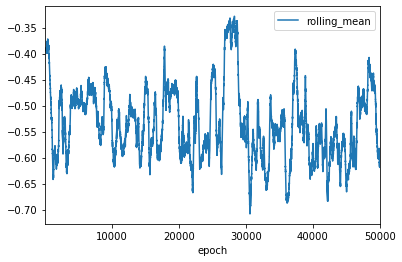

In [106]:
df.head(50000).plot(y="rolling_mean", x="epoch")

In [108]:
df

""


In [ ]:
result = "Results/runs_{}_alpha_{}_gamma_{}_cache_{}.csv".format(number_of_runs, alpha, gamma, cache_size)

In [ ]:
df.to_csv(result)